# Coding vs non-coding
K-mer count features extracted from GenCode pc and nc RNA. 
Use GenCode 34. 
Use one RNA per gene; the one transcript with median length (use floor where count is even).

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
ncfile='ncRNA.2mer.features.csv'
nc_features = pd.read_csv(ncfile,header=0)
nc_features.head()
# Our non-coding sequence numbers start at 1. 

,seqnum,seqlen,AA,AC,AG,AT,CA,CC,CG,CT,GA,GC,GG,GT,TA,TC,TG,TT
0,1,535,39,21,38,30,31,48,11,44,31,30,26,28,27,36,40,54
1,2,590,37,21,47,27,43,55,9,51,35,42,55,26,18,40,46,37
2,3,629,61,30,53,41,48,41,5,45,48,30,31,32,28,38,51,46
3,4,1319,109,68,127,77,110,75,16,82,106,79,100,58,57,61,100,93
4,5,323,16,21,26,12,28,23,4,21,24,23,31,19,7,9,37,21


In [34]:
pcfile='pcRNA.2mer.features.csv'
pc_features = pd.read_csv(pcfile,header=0)
pc_features.head()
# Our protein-coding sequence numbers start at 50,000.

,seqnum,seqlen,AA,AC,AG,AT,CA,CC,CG,CT,GA,GC,GG,GT,TA,TC,TG,TT
0,50000,1054,62,56,53,91,78,57,13,91,55,38,40,65,67,89,92,106
1,50001,995,41,54,54,66,79,68,8,99,48,42,47,63,46,90,92,97
2,50002,995,41,54,54,66,79,68,8,99,48,42,47,63,46,90,92,97
3,50003,2191,75,104,173,42,154,305,136,162,143,236,259,68,22,111,138,62
4,50004,2757,123,131,251,77,201,234,124,219,219,254,273,125,40,159,222,104


In [38]:
nc_features.shape, pc_features.shape

((17959, 18), (20365, 18))

In [43]:
# Longest sequence in each class.
# Yes, there is a 200Kb lncRNA!
nc_features['seqlen'].max(), pc_features['seqlen'].max()

(205012, 21470)

In [44]:
# Shortes sequence in each class
nc_features['seqlen'].min(), pc_features['seqlen'].min()

(32, 8)

In [22]:
nc_labels_temp=[0]*nc_features.shape[0]
pc_labels_temp=[1]*pc_features.shape[0]
nc_labels=pd.core.frame.DataFrame(nc_labels_temp)
pc_labels=pd.core.frame.DataFrame(pc_labels_temp)
nc_labels.shape, pc_labels.shape

((17959, 1), (20365, 1))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ffd5847cdf0>]],
      dtype=object)

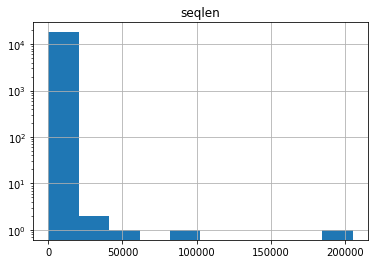

In [45]:
# There appears to be 3 outliers at 50Kb, 100Kb, and 200Kb. 
nc_features.hist(column='seqlen',bins=10, log=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ffd58521e50>]],
      dtype=object)

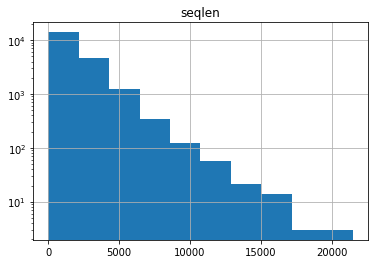

In [46]:
Exponential decay till about 15Kb.
pc_features.hist(column='seqlen',bins=10, log=True)

In [59]:
truefalse=nc_features.apply(lambda x: True if x['seqlen'] >= 50000 else False, axis=1)
truefalse[truefalse==True]

9343     True
10859    True
dtype: bool

In [66]:
nc_features.loc[truefalse[truefalse==True].index]

,seqnum,seqlen,AA,AC,AG,AT,CA,CC,CG,CT,GA,GC,GG,GT,TA,TC,TG,TT
9343,9344,91667,10727,5299,7483,6497,7598,5395,763,5846,6409,4305,5883,3875,5272,4603,6343,5368
10859,10860,205012,18285,9028,13529,17526,13220,8962,1014,14587,11867,7086,9317,11454,14997,12707,15863,25569


In [77]:
#nc_features.drop(labels=truefalse[truefalse==True].index)
new_nc_features=nc_features.drop([9343,10859])

In [78]:
truefalse=new_nc_features.apply(lambda x: True if x['seqlen'] >= 50000 else False, axis=1)
truefalse[truefalse==True]

Series([], dtype: bool)